In [1]:
import galsim
from matplotlib import pyplot as plt
plt.style.use(['dark_background'])
%matplotlib inline

import numpy as np
from SpecklePSF import SpeckleSeries
import pickle
import helperFunctions as helper
import pandas as pd

### HSM with simulated profiles

In [2]:
galaxy = galsim.Gaussian(flux=1.0, sigma=1.0).shear(g1=.01, g2=.03).drawImage(scale=0.2)

In [3]:
new_params = galsim.hsm.HSMParams(max_amoment=5.0e5, max_mom2_iter=1000)
moments = galsim.hsm.FindAdaptiveMom(galaxy, hsmparams=new_params)

In [4]:
print(f'Error in g1: {abs(.01 - moments.observed_shape.g1)*100:.4f}%')
print(f'Error in g2: {abs(.03 - moments.observed_shape.g2)*100:.4f}%')

Error in g1: 0.0033%
Error in g2: 0.0100%


### HSM on integrated speckles: testing

centroid guess: (122, 144) 
sigma guess: 20.38216560509554


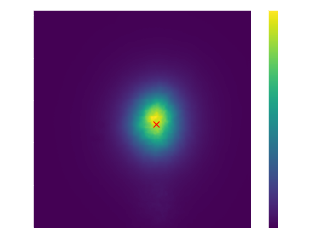

In [5]:
scratchdir = '/global/cscratch1/sd/chebert/'
# this runs the loadMinimalExposures -- so we have 15 accumulated exposures in. 
test = SpeckleSeries('234', 'data', scratchdir)
fullExposure = test.bSeq[-1]

# find first guess of sigma:
comx, comy = helper.imageCOM(fullExposure)
fwhm = helper.imageFWHM(fullExposure, comx, comy)
guestimateSig = fwhm / 2.355
print(f'centroid guess: {comx, comy} \nsigma guess: {guestimateSig}')

# last of the 15 loaded images, so full minute exposure. This has no gain:
plt.imshow(fullExposure, origin='lower')
plt.plot(comy, comx, 'rx')
plt.colorbar()
plt.show()

In [6]:
# make GalSim image of the exposure
fullExpImage = galsim.Image(fullExposure, xmin=0, ymin=0)

# run HSM adaptive moments with initial sigma guess
new_params = galsim.hsm.HSMParams(max_amoment=5.0e8, max_mom2_iter=1000, max_ashift=25)
speckleMoments = galsim.hsm.FindAdaptiveMom(fullExpImage, 
                                            hsmparams=new_params, 
                                            precision=1e-4,
                                            guess_sig=guestimateSig,
                                            guess_centroid=galsim.PositionD(comx, comy))

In [7]:
# tuple of results
speckleMoments.observed_shape.g1, speckleMoments.observed_shape.g2, speckleMoments.moments_sigma

(-0.10714565488507198, 0.012207228283869003, 22.89712905883789)

In [8]:
# find factor to convert from moment_sigma to HLR:
hlr = .35
k = galsim.Kolmogorov(half_light_radius=hlr, flux=1)
k = k.shear(g1=.02, g2=0)
kIm = k.drawImage(nx=256, ny=256, scale=.01, offset=(0, 0))

testres = kIm.FindAdaptiveMom()
testres.moments_sigma

hlrSigmaconversion = hlr / testres.moments_sigma

## HSM results of 8 sets:

In [9]:
comparisonFiles = ['025', '1262', '234', '258', '484', '663', '693', '809']

### Full exposures first

In [ ]:
hsmAg1 = {}
hsmBg1 = {}
hsmAg2 = {}
hsmBg2 = {}

for file in ag1.keys():
    print(file)
    test = SpeckleSeries(file, 'data', scratchdir)

    # find HSM result for filter a
    fullExposure = test.aSeq[-1]
    comx, comy = helper.imageCOM(fullExposure)
    fwhm = helper.imageFWHM(fullExposure, comx, comy)
    guestimateSig = fwhm / 2.355

    new_params = galsim.hsm.HSMParams(max_amoment=5.0e5, max_ashift=75)
    fullExpImage = galsim.Image(fullExposure, xmin=0, ymin=0)
    speckleMoments = galsim.hsm.FindAdaptiveMom(fullExpImage, hsmparams=new_params,
                                                guess_sig=guestimateSig,
                                                guess_centroid=galsim.PositionD(comx, comy))
    hsmAg1[file] = speckleMoments.observed_shape.g1
    hsmAg2[file] = speckleMoments.observed_shape.g2
    
    # find HSM result for filter b
    fullExposure = test.bSeq[-1]
    comx, comy = helper.imageCOM(fullExposure)
    fwhm = helper.imageFWHM(fullExposure, comx, comy)
    guestimateSig = fwhm / 2.355

    fullExpImage = galsim.Image(fullExposure, xmin=0, ymin=0)
    speckleMoments = galsim.hsm.FindAdaptiveMom(fullExpImage, hsmparams=new_params, 
                                                guess_sig=guestimateSig)
    hsmBg1[file] = speckleMoments.observed_shape.g1
    hsmBg2[file] = speckleMoments.observed_shape.g2

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(221)
i = 0
for (k,v) in hsmAg1.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, ag1[k], 'x', label='Kolmogorov')
    if i==0:
        plt.legend(loc=4)
    i += 1
plt.title('a filter')
plt.ylabel('g1')
    
plt.subplot(222)
i = 0
for (k,v) in hsmBg1.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, bg1[k], 'x', label='Kolmogorov')
    i += 1
plt.title('b filter')
plt.ylabel('g1')

plt.subplot(223)
i = 0
for (k,v) in hsmAg2.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, ag2[k], 'x', label='Kolmogorov')
    i += 1
plt.ylabel('g2')
plt.xlabel('data set') 

plt.subplot(224)
i = 0
for (k,v) in hsmBg2.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, bg2[k], 'x', label='Kolmogorov')
    i += 1
plt.ylabel('g2')
plt.xlabel('data set')
plt.show()

### All (15) exposure lengths

In [10]:
# load com and fwhm 
with open('./../Fits/centerOfMassB.p', 'rb') as file:
    comDictB = pickle.load(file)
with open('./../Fits/fwhmB.p', 'rb') as file:
    fwhmDictB = pickle.load(file)

with open('./../Fits/centerOfMassA.p', 'rb') as file:
    comDictA = pickle.load(file)
with open('./../Fits/fwhmA.p', 'rb') as file:
    fwhmDictA = pickle.load(file)

In [11]:
scratchdir = '/global/cscratch1/sd/chebert/'

# fitting with HSM function -- to be transfered into SpecklePSF class!
def fitHSM(img):
    comx, comy = helper.imageCOM(img)
    fwhm = helper.imageFWHM(img, comx, comy)
    guestimateSigA = fwhm / 2.355

    # make GalSim image of the exposure
    new_params = galsim.hsm.HSMParams(max_amoment=5.0e5, max_ashift=75)
    galImage = galsim.Image(img, xmin=0, ymin=0)
    # run HSM adaptive moments with initial sigma guess
    speckleMoments = galsim.hsm.FindAdaptiveMom(galImage, hsmparams=new_params,
                                                guess_sig=guestimateSig,
                                                guess_centroid=galsim.PositionD(comx, comy))

    # tuple of results
    return speckleMoments.observed_shape.g1, speckleMoments.observed_shape.g2, speckleMoments.moments_sigma

In [12]:
# find HSM results
fullAg1, fullBg1, fullAg2, fullBg2, fullASig, fullBSig = {}, {}, {}, {}, {}, {}

for file in comparisonFiles:
    test = SpeckleSeries(file, 'data', scratchdir)
    a1, b1, a2, b2, asig, bsig  = np.ones(15), np.ones(15), np.ones(15), np.ones(15), np.ones(15), np.ones(15)
    for i in range(15):
        imgA = test.aSeq[i]
        imgB = test.bSeq[i]
        
        a1[i], a2[i], asig[i] = fitHSM(imgA)
        b1[i], b2[i], bsig[i] = fitHSM(imgB)
    fullAg1[file] = a1
    fullAg2[file] = a2
    fullBg1[file] = b1
    fullBg2[file] = b2
    fullASig[file] = asig
    fullBSig[file] = bsig

### g1

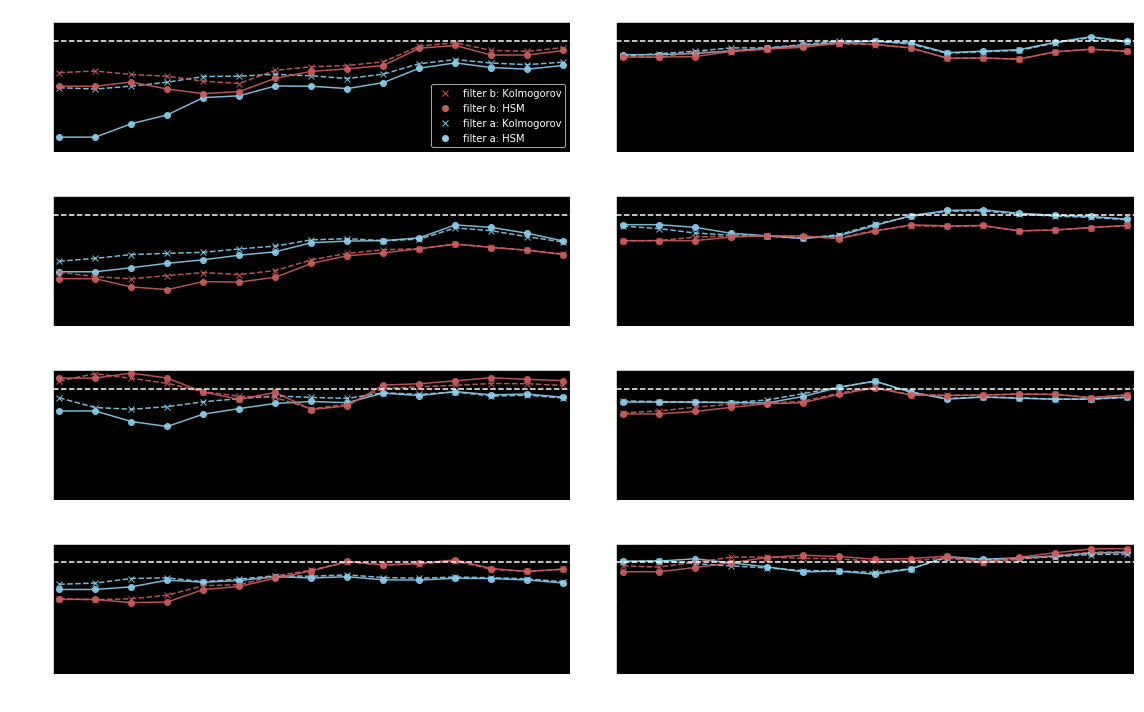

In [13]:
g = 'g1'
pts = np.logspace(-1.22,1.79,15)
plt.figure(figsize=(16, 10))

i = 1
for (k, v) in fullAg1.items():
    plt.subplot(4,2,i)
    fitFile = g + '/' + g + '_img_a_' + k + 'cumulative.txt'
    kFits = np.loadtxt('../Fits/kolmogorovFits/' + fitFile, delimiter=',')
    plt.plot(pts, kFits[:,1], 'x--', color='skyblue', alpha=0.9)
    plt.plot(pts, v, 'o-', color='skyblue', alpha=0.9)

    fitFile = g + '/' + g + '_img_b_' + k + 'cumulative.txt'
    kFits = np.loadtxt('../Fits/kolmogorovFits/' + fitFile, delimiter=',')
    plt.plot(pts, kFits[:,1], 'x--', color='indianred', alpha=0.9)
    plt.plot(pts, fullBg1[k], 'o-', color='indianred', alpha=0.9)
    
    plt.axhline(0, linestyle='--', color='w')
    plt.ylim([-.3, .05])
    plt.xscale('log')
    plt.xlim((0.055,.068*1000))
    plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])

    criteria = comDictA['img_a_' + k + '.fits'] + 2 * fwhmDictA['img_a_' + k + '.fits']
    status = 'rejected' if criteria > 128 else 'accepted'
    plt.title(f'file {k}, {status}, criteria={criteria:.1f}')
    if i%2 == 1:
        plt.ylabel('g1')
    i += 1

plt.xlabel('exposure time')    
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='indianred', lw=0, marker='x', label='filter b: Kolmogorov'),
                   Line2D([0], [0], color='indianred', lw=0, marker='o', label='filter b: HSM'),
                   Line2D([0], [0], color='skyblue', lw=0, marker='x', label='filter a: Kolmogorov'),
                   Line2D([0], [0], color='skyblue', lw=0, marker='o', label='filter a: HSM')
                  ]
plt.subplot(4,2,1)
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

### g2

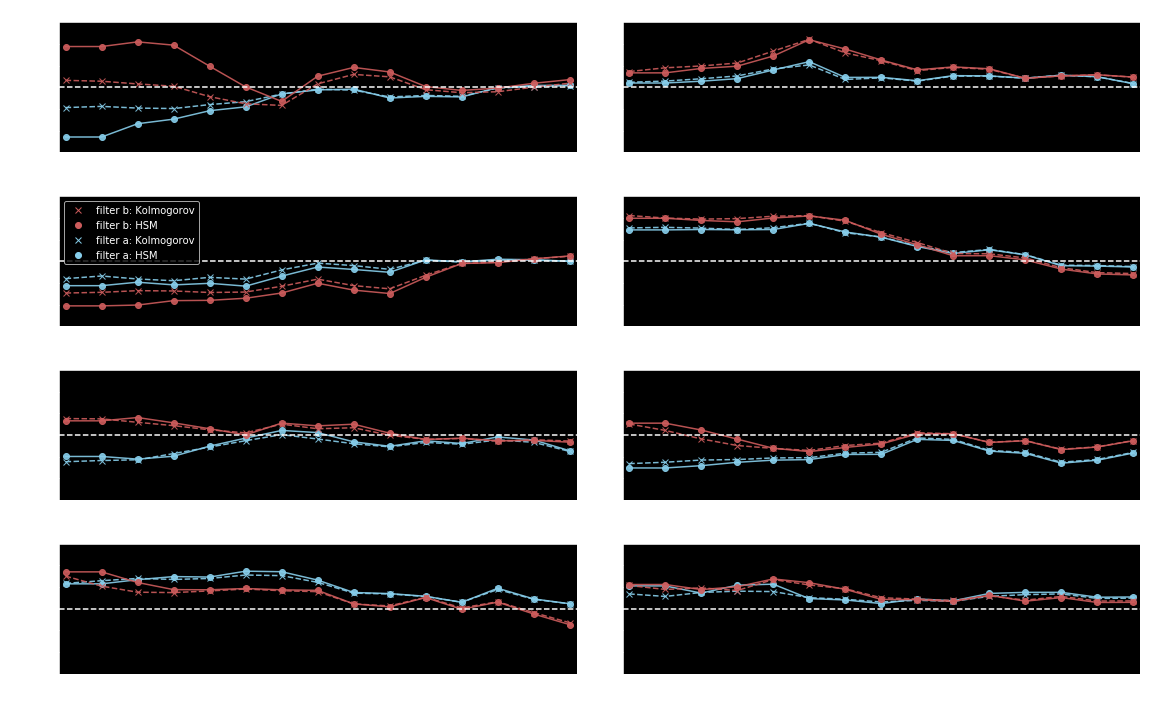

In [14]:
g = 'g2'
pts = np.logspace(-1.22,1.79,15)

plt.figure(figsize=(16, 10))
i = 1

for (k, v) in fullAg2.items():
    plt.subplot(4,2,i)
    fitFile = g + '/' + g + '_img_a_' + k + 'cumulative.txt'
    kFits = np.loadtxt('../Fits/kolmogorovFits/' + fitFile, delimiter=',')
    plt.plot(pts, kFits[:,1], 'x--', color='skyblue', alpha=0.9)
    plt.plot(pts, v, 'o-', color='skyblue', alpha=0.9)

    fitFile = g + '/' + g + '_img_b_' + k + 'cumulative.txt'
    kFits = np.loadtxt('../Fits/kolmogorovFits/' + fitFile, delimiter=',')
    plt.plot(pts, kFits[:,1], 'x--', color='indianred', alpha=0.9)
    plt.plot(pts, fullBg2[k], 'o-', color='indianred', alpha=0.9)
    
    plt.axhline(0, linestyle='--', color='w')
    plt.ylim([-.15, .15])
    plt.xscale('log')
    plt.xlim((0.055,.068*1000))
    plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])
    
    criteria = comDictA['img_a_' + k + '.fits'] + 2 * fwhmDictA['img_a_' + k + '.fits']
    status = 'rejected' if criteria > 128 else 'accepted'
    plt.title(f'file {k}, {status}, criteria={criteria:.1f}')

    if i%2 == 1:
        plt.ylabel('g2')
    i += 1

plt.xlabel('exposure time')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='indianred', lw=0, marker='x', label='filter b: Kolmogorov'),
                   Line2D([0], [0], color='indianred', lw=0, marker='o', label='filter b: HSM'),
                   Line2D([0], [0], color='skyblue', lw=0, marker='x', label='filter a: Kolmogorov'),
                   Line2D([0], [0], color='skyblue', lw=0, marker='o', label='filter a: HSM')
                  ]
plt.subplot(4,2,3)
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

## size: HLR

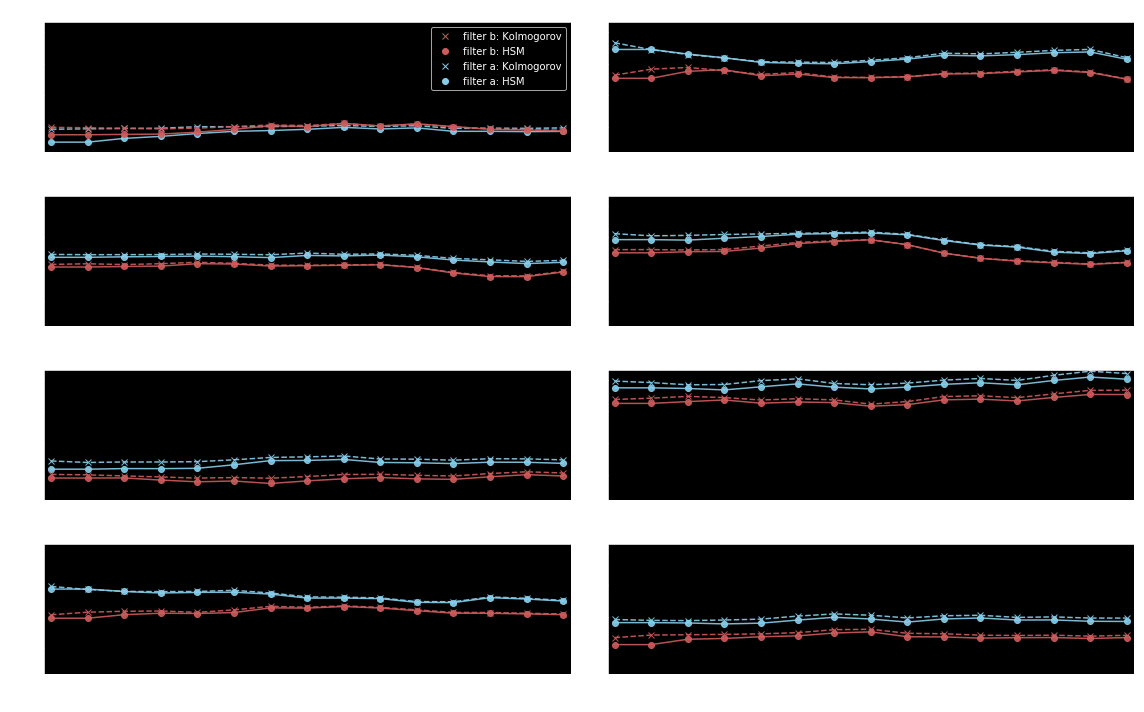

In [20]:
g = 'hlr'
pts = np.logspace(-1.22,1.79,15)
plt.figure(figsize=(16, 10))

i = 1
for (k, v) in fullASig.items():
    plt.subplot(4,2,i)
    fitFile = g + '/' + g + '_img_a_' + k + 'cumulative.txt'
    kFits = np.loadtxt('../Fits/kolmogorovFits/' + fitFile, delimiter=',')
    plt.plot(pts, kFits[:,1], 'x--', color='skyblue', alpha=0.9)
    plt.plot(pts, v*hlrSigmaconversion, 'o-', color='skyblue', alpha=0.9)

    fitFile = g + '/' + g + '_img_b_' + k + 'cumulative.txt'
    kFits = np.loadtxt('../Fits/kolmogorovFits/' + fitFile, delimiter=',')
    plt.plot(pts, kFits[:,1], 'x--', color='indianred', alpha=0.9)
    plt.plot(pts, fullBSig[k]*hlrSigmaconversion, 'o-', color='indianred', alpha=0.9)
    
#     plt.axhline(0, linestyle='--', color='w')
    plt.ylim([.12, .53])
    plt.xscale('log')
    plt.xlim((0.055,.068*1000))
    plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])

    criteria = comDictA['img_a_' + k + '.fits'] + 2 * fwhmDictA['img_a_' + k + '.fits']
    status = 'rejected' if criteria > 128 else 'accepted'
    plt.title(f'file {k}, {status}, criteria={criteria:.1f}')
    if i%2 == 1:
        plt.ylabel('HLR')
    i += 1

plt.xlabel('exposure time')    
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='indianred', lw=0, marker='x', label='filter b: Kolmogorov'),
                   Line2D([0], [0], color='indianred', lw=0, marker='o', label='filter b: HSM'),
                   Line2D([0], [0], color='skyblue', lw=0, marker='x', label='filter a: Kolmogorov'),
                   Line2D([0], [0], color='skyblue', lw=0, marker='o', label='filter a: HSM')
                  ]
plt.subplot(4,2,1)
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

### HLR ratios:

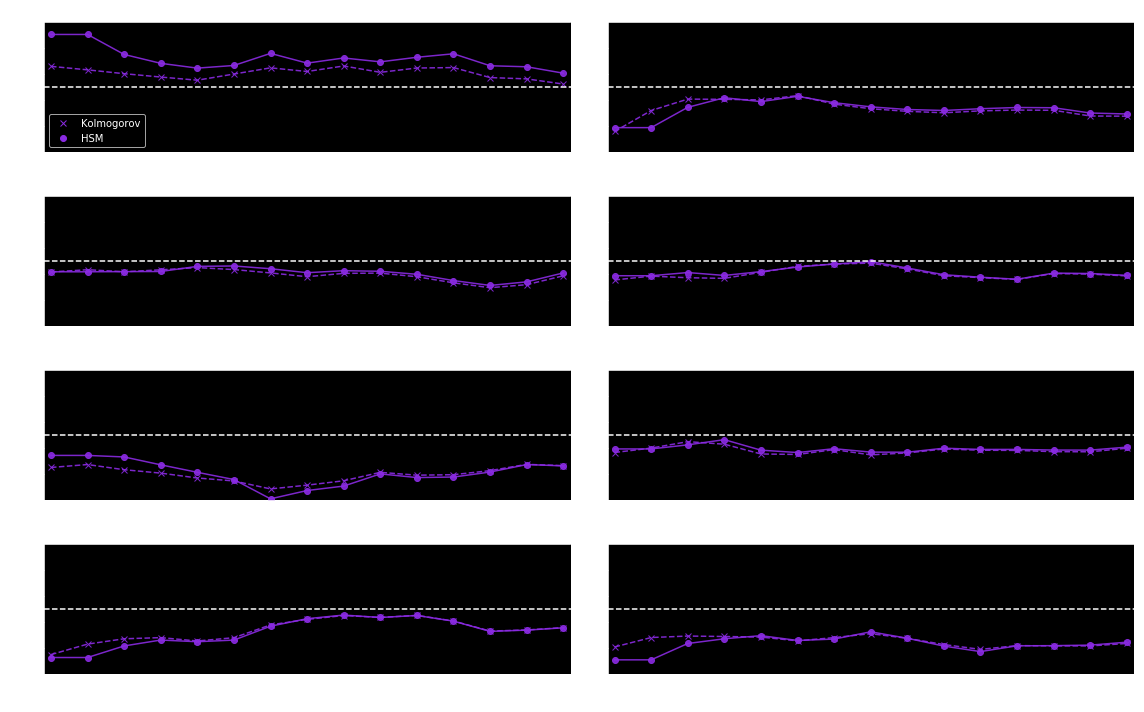

In [25]:
g = 'hlr'
pts = np.logspace(-1.22,1.79,15)
plt.figure(figsize=(16, 10))

i = 1
for (k, v) in fullASig.items():
    plt.subplot(4,2,i)

    fitFileA = g + '/' + g + '_img_a_' + k + 'cumulative.txt'
    kFitsA = np.loadtxt('../Fits/kolmogorovFits/' + fitFileA, delimiter=',')
    
    fitFileB = g + '/' + g + '_img_b_' + k + 'cumulative.txt'
    kFitsB = np.loadtxt('../Fits/kolmogorovFits/' + fitFileB, delimiter=',')

    plt.plot(pts, kFitsB[:,1] / kFitsA[:,1], 'x--', color='blueviolet', alpha=0.9)
    plt.plot(pts,  fullBSig[k] / v, 'o-', color='blueviolet', alpha=0.9)
    
    plt.axhline(.95, linestyle='--', color='w')
    plt.ylim([.7, 1.2])
    plt.xscale('log')
    plt.xlim((0.055,.068*1000))
    plt.xticks([.06, 1, 10, 60],[.06, 1, 10, 60])

    criteria = comDictA['img_a_' + k + '.fits'] + 2 * fwhmDictA['img_a_' + k + '.fits']
    status = 'rejected' if criteria > 128 else 'accepted'
    plt.title(f'file {k}, {status}, criteria={criteria:.1f}')
    if i%2 == 1:
        plt.ylabel('HLR ratio b:a')
    i += 1

plt.xlabel('exposure time')    
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blueviolet', lw=0, marker='x', label='Kolmogorov'),
                   Line2D([0], [0], color='blueviolet', lw=0, marker='o', label='HSM')
                  ]
plt.subplot(4,2,1)
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()